In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Training compute-optimal Perceiver AR language models

An application of the *Chinchilla* paper

**Work in progress ...** 

## Introduction

In [Training Compute-Optimal Large Language Models](https://arxiv.org/abs/2203.15556) \[1\] (the *Chinchilla* paper) the authors describe how to determine the optimal model size $N_{opt}$ and number of training tokens $D_{opt}$ for a given compute budget $C$, and how $N_{opt}$ and $D_{opt}$ scale with $C$. These scaling laws are applicable to decoder-only transformer language models. 

In this article I describe how I applied these scaling laws to [Perceiver AR](https://arxiv.org/abs/2202.07765) \[2\] language models and discuss the experimental results. Perceiver AR is a simple extension to a decoder-only transformer, introducing cross-attention to a longer prefix sequence. I run Perceiver AR scaling experiments on small scale, for model sizes ranging from 17M to 108M parameters, but the very same approach can also be used at larger scale. 

## Scaling laws

The *Chinchilla* paper \[1\] assumes a power law relationship between compute $C$ and compute-optimal model size $N_{opt}$ and number of training tokens $D_{opt}$.

$$
\begin{align}
N_{opt} &\propto C^a \\
D_{opt} &\propto C^b
\end{align} \tag{1}
$$

The authors use three different approaches to determine exponents $a$ and $b$, and obtain similar results. For approach 1 $a=0.50$ and $b=0.50$, for approach 2 $a = 0.49$, $b = 0.51$. I skip approach 3 as it is not used in this article.

This suggest that the number of model parameters and number of training tokens should be scaled more or less equally with compute $C$. For actually calculating $N_{opt}$ and $D_{opt}$ from $C$ we still need the factors of proportionality $k_N$ and $k_D$:

$$
\begin{align}
N_{opt} &= k_N C^a \\
D_{opt} &= k_D C^b
\end{align} \tag{2}
$$

The paper doesn't provide these factors directly, but they can be derived from estimates of $N_{opt}$ and $D_{opt}$ for different compute budgets $C$. These estimates are provided in Tables 3 and A3 in \[1\]. By fitting $(2)$ to these estimates

In [2]:
from scaling.laws import fit_scaling_law

# Estimates from Table 3 in [1]
df_1 = pd.read_csv("data/estimates/approach_1.csv")
# Estimates from Table A3 in [1]
df_2 = pd.read_csv("data/estimates/approach_2.csv")

scaling_law_1 = fit_scaling_law(df_1["FLOPs"], df_1["Parameters"], df_1["Tokens"], a=0.50, b=0.50)
scaling_law_2 = fit_scaling_law(df_2["FLOPs"], df_2["Parameters"], df_2["Tokens"], a=0.49, b=0.51)

we obtain

In [3]:
print(scaling_law_1)

N_opt = 0.0877 * C ** 0.50
D_opt = 1.8960 * C ** 0.50


for approach 1 and

In [4]:
print(scaling_law_2)

N_opt = 0.1448 * C ** 0.49
D_opt = 1.1519 * C ** 0.51


for approach 2. 

## Perceiver AR

Perceiver AR is a simple extension of a plain decoder-only transformer such as GPT-2, for example. A core building block of both is the *decoder layer* consisting of a self-attention layer followed by a position-wise MLP. Self-attention uses a causal attention mask.

Perceiver AR additionally cross-attends to a longer prefix of the input sequence in its first attention layer. This layer is a hybrid self- and cross-attention layer. Self-attention is over the last n positions of the input sequence, with a causal attention mask, cross-attention is from the last $n$ positions to the first $m$ positions. The length of the input sequence is $m + n$. This allows a Perceiver AR to process a much larger context than decoder-only transformers which are based on self-attention only.

<figure>
<img src=images/perceiver-ar.png style="width:75%"/>
<center><i>Fig. 1</i>. Attention in Perceiver AR with $m = 8$ prefix tokens and $n = 3$ latent tokens.</center>
</figure>

The output of the hybrid attention layer are $n$ latent arrays corresponding to the last $n$ tokens of the input sequence. These are further processed by a stack of $L - 1$ decoder layers where the total number of attention layers is $L$. A final layer (not shown in Fig. 1) predicts the target token for each latent position. The weights of the final layer are shared with the input embedding layer.

Except for the initial cross-attention to the prefix sequence, a Perceiver AR is architecturally identical to a decoder-only transformer. In the following, I refer to this part of Perceiver AR as the *self-attention part* and to the last n tokens of the input sequence as *latent tokens*. 

The self-attention part includes input and position embedding of latent tokens, self-attention followed by a position-wise MLP in the hybrid layer and all decoder layers, and target token prediction in the final output layer. The remaining *cross-attention part* includes input and position embedding of the prefix tokens and cross-attention from latent positions to prefix positions. 

## Compute estimates

For estimating the FLOPs required to train Perceiver AR models I'm following \[4\] for reasons explained in \[5\]. An equivalent implementation is in class `ComputeEstimator`. The training FLOPs per latent token for the self-attention part of Perceiver AR can be estimated with the `self_attn()` method. The training FLOPs per latent token for the initial cross-attention can be estimated with `cross_attn()`. An example:

In [5]:
from scaling.flops import ComputeEstimator

ce = ComputeEstimator(max_seq_len=2048, num_latents=512)

num_channels = 512
num_layers = 9
num_heads = 8

c_self = ce.self_attn(num_channels, num_heads, num_layers)
print(f"Self-attention training FLOPs per latent token: {c_self:.2e}")

c_cross = ce.cross_attn(num_channels, num_heads, prefix_dropout=0.5)
print(f"Cross-attention training FLOPs per latent token: {c_cross:.2e}")

cross_fraction = c_cross / (c_cross + c_self)
print(f"Cross-attention contribution to overall compute: {cross_fraction * 100:.2f}%")

Self-attention training FLOPs per latent token: 1.99e+08
Cross-attention training FLOPs per latent token: 9.49e+06
Cross-attention contribution to overall compute: 4.56%


The `self_attn()` method can also be used for estimating the training FLOPs of plain decoder-only transformer models. The results from this method are very close to the common $C \approx 6N$ approximation where $N$ is the number of model parameters including embedding weights.

In [6]:
from scaling.flops import num_self_attn_params

n_self = num_self_attn_params(
    num_channels=num_channels, 
    num_layers=num_layers, 
    num_latents=ce.num_latents, 
    num_prefix=ce.num_prefix, 
    vocab_size=32000,
)

# Simple approximation of training FLOPs (per latent token)
c_self_approx = 6 * n_self

print(f"C_self / C_self_approx = {c_self / c_self_approx:.2f}")

C_self / C_self_approx = 0.74


The scaling laws in \[1\] have been derived from training decoder-only transformers, hence, they can only be applied to the self-attention part of Perceiver AR. For calculating $N_{opt}$, we must therefore use the estimated training FLOPs of the self-attention part.

The cross-attention part requires extra compute. Its contribution to the overall compute increases with prefix sequence length and decreases with the number of decoder layers i.e. model size. It makes up only a few percent of the overall compute for models used in the following experiments.

## Experiments

Each of the following experiments start from a Perceiver AR *reference model*, a model of given size that has been trained with a given number of latent training tokens $D_{ref}$, resulting in an estimated compute budget $C_{ref}$. For this reference compute budget, a compute-optimal model size $N_{opt}$ is calculated with a scaling law.

The next step is to design a Perceiver AR model with a number of (self-attention) parameters $N_{self}$ that is close to $N_{opt}$. This predicted compute-optimal model and the reference model are trained with the same (self-attention) compute budget $C_{self} = C_{ref}$ to verify that the final loss of the predicted compute-optimal model is less than that of the reference model.

Some experiments include further models, smaller and/or larger than the predicted compute-optimal model and the reference model, to further verify the validity of predictions. The number of latent training tokens $D_{iso}$ is chosen such that all models of an experiment are trained with the same compute budget $C_{self} = C_{ref}$. 

All models are trained with a global batch size of `80` sequences where each sequence contains n = 512 latent tokens plus an variable number of prefix tokens depending on the experiment. All training commands are documented [here](https://github.com/krasserm/perceiver-io/blob/main/examples/scaling/clm/train.md).

In [7]:
batch_size = 80
num_latents = 512
num_heads = 8

All experiments use an Adam optimizer with a maximum learning rate of $2\mathrm{e}{-4}$ which is decayed to $10\%$ over $D_{iso}$ tokens with a cosine schedule. Warmup is over the first $200$ steps. Datasets have been chosen to meet the *less than an epoch of data* condition (with an [approximation](https://github.com/krasserm/perceiver-io/blob/main/examples/scaling/clm/train.md#approximations)).

### Experiment 1

This experiment [trains](https://github.com/krasserm/perceiver-io/blob/main/examples/scaling/clm/train.md#experiment-1) a series of Perceiver AR models that use a [SentencePiece](https://arxiv.org/abs/1808.06226) tokenizer, as in \[1\], with a vocabulary of size $32,000$. The prefix length $m = 1536$. The training dataset is [bookcorpusopen](https://huggingface.co/datasets/bookcorpusopen). 

In [8]:
vocab_size = 32000

ce = ComputeEstimator(max_seq_len=2048, num_latents=512)
print(f"Prefix length = {ce.num_prefix}")

Prefix length = 1536


The reference model is defined with `num_channels=512` and `num_layers=9` where `num_channels` is the model dimension and `num_layers` the number of attention layers including the initial hybrid attention layer. It has $N = 4.58\mathrm{e}{+7}$ parameters, with $N_{self} = 4.50\mathrm{e}{+7}$ parameters in the self-attention part. When trained with $D_{ref} = 2.05\mathrm{e}{+9}$ latent tokens (= $50,000$ steps) the estimated compute budget $C_{self} = C_{ref} = 5.78\mathrm{e}{+17}$.

In [9]:
from scaling.flops import ModelInfo, training_flops

m_ref = ModelInfo(vocab_size=vocab_size, num_channels=512, num_layers=9, num_heads=num_heads, compute_estimator=ce)
c_ref, d_ref = training_flops(ref_model=m_ref, num_steps=50000, batch_size=batch_size)

print(f"C_ref = {c_ref:.2e} FLOPs")
assert c_ref == ce.self_attn(m_ref.num_channels, m_ref.num_heads, m_ref.num_layers) * d_ref

C_ref = 4.07e+17 FLOPs


For this compute budget, a compute-optimal model size can be predicted. With `scaling_law_2`, for example, the compute-optimal model size $N_{opt} = 7.32\mathrm{e}{+7}$ parameters.

In [10]:
print(f"N_opt (approach 2) = {scaling_law_2.n_opt(c_ref):.2e}")

N_opt (approach 2) = 6.16e+07


A Perceiver AR model with `num_channels=624` and `num_layers=11` has $N_{self} = 7.17\mathrm{e}{+7}$ self-attention parameters which comes close to $N_{opt}$. It will be used as the predicted compute-optimal model.

In [11]:
m_pred = ModelInfo(vocab_size=vocab_size, num_channels=592, num_layers=10, num_heads=num_heads, compute_estimator=ce)
print(f"N_self = {m_pred.num_self_attn_params():.2e}")

N_self = 6.14e+07


These models are summarized in Tables 1 and 2. Model 1 is the reference model and model 2 is the predicted compute-optimal model. For having models both smaller and larger than the predicted compute optimal model a third model with $N_{self} = 1.06\mathrm{e}{+8}$ parameters is added.

In [12]:
from article import experiment_setup

models = [m_ref, m_pred, ModelInfo(vocab_size=vocab_size, num_channels=728, num_layers=13, num_heads=num_heads, compute_estimator=ce)]
experiment_setup(models, c_ref=c_ref, batch_size=batch_size)

,num_channels,num_layers,num_steps,$D_{iso}$,$N$,$N_{cross}$,$N_{self}$,$C$,$C_{cross}$,$C_{self}$,$\hat{C}_{self}$
1,512,9,50000,2.05e+09,4.58e+07,7.86e+05,4.50e+07,4.26e+17,1.94e+16,4.07e+17,5.53e+17
2,592,10,34336,1.41e+09,6.23e+07,9.09e+05,6.14e+07,4.23e+17,1.66e+16,4.07e+17,5.18e+17
3,728,13,17894,7.33e+08,1.08e+08,1.12e+06,1.06e+08,4.19e+17,1.20e+16,4.07e+17,4.68e+17


<figure>
<i>Table 1</i>: Experiment 1 setup.  <code>num_channels</code>: model dimension, <code>num_layers</code>: number of attention layers: $N = N_{cross} + N_{self}$: number of model parameters, $C = C_{cross} + C_{self}$: training FLOPs, $\hat{C}_{self}$: training FLOPs with $6 N_{self} D_{iso}$ approximation,  $D_{iso}$: number of latent training tokens required for compute budget $N_{self}$, <code>num_steps</code>: number of training steps required for compute budget $N_{self}$.
</figure>

In [13]:
from article import experiment_ratios

experiment_ratios(models)

,$N_{cross} \over N$,$C_{cross} \over C$,${C_{self}} \over {\hat{C}_{self}}$
1,0.0172,0.0456,0.7351
2,0.0146,0.0393,0.7852
3,0.0104,0.0286,0.8687


<figure>
<i>Table 2</i>: Experiment 1 ratios. Contribution of the cross-attention part to the total number of parameters $N$ and the full compute $C$. $C_{self} / \hat{C}_{self}$ ratios are similar to those in Table A4 in [1].
</figure>

When training these models under the same self-attention compute budget $C_{self} = C_{ref}$, we can see that the final validation loss of the compute-optimal model is actually less than that of the two other models, consistent with the prediction from the scaling law. The self-attention compute budget $C_{self}$ is indicated by a vertical dashed line.

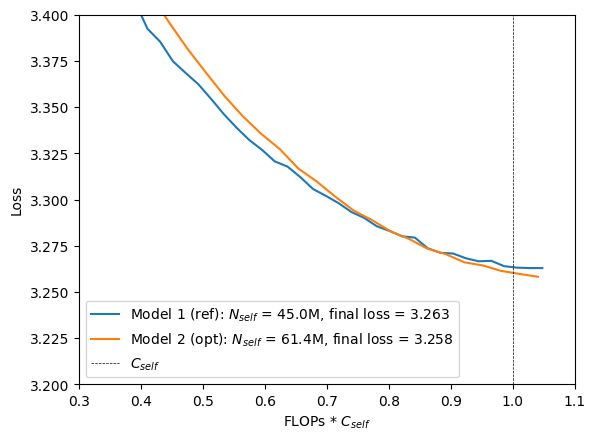

In [14]:
from article import plot_experiment

model_labels = ["Model 1 (ref)", "Model 2 (opt)", "Model 3"]

# Exclude model 3 temporarily, not updated yet ...
plot_experiment(models[:2], model_labels, experiment_name="scaling-1")
plt.xlim(0.3, 1.1)
plt.ylim(3.2, 3.4);

### Experiment 2a

This experiment [trains](https://github.com/krasserm/perceiver-io/blob/main/examples/scaling/clm/train.md#experiment-2a) a series of Perceiver AR models that use a UTF-8 bytes tokenizer with a vocabulary of size $262$ ($= 256 + 6$ special tokens). The prefix sequence has $m = 3584$ tokens i.e. $2048$ tokens more than in Experiment 1. The training dataset is [bookcorpus](https://huggingface.co/datasets/bookcorpus). 

In [15]:
vocab_size = 262

ce = ComputeEstimator(max_seq_len=4096, num_latents=num_latents)
m_ref = ModelInfo(vocab_size=vocab_size, num_channels=512, num_layers=9, num_heads=num_heads, compute_estimator=ce)
models = [
    m_ref,
    ModelInfo(vocab_size=vocab_size, num_channels=584, num_layers=10, num_heads=num_heads, compute_estimator=ce),
    ModelInfo(vocab_size=vocab_size, num_channels=584, num_layers=9, num_heads=num_heads, compute_estimator=ce),
    ModelInfo(vocab_size=vocab_size, num_channels=432, num_layers=7, num_heads=num_heads, compute_estimator=ce),
    ModelInfo(vocab_size=vocab_size, num_channels=768, num_layers=13, num_heads=num_heads, compute_estimator=ce),
]

c_ref, d_ref = training_flops(ref_model=m_ref, num_steps=26144, batch_size=batch_size)

experiment_setup(models, c_ref=c_ref, batch_size=batch_size)

,num_channels,num_layers,num_steps,$D_{iso}$,$N$,$N_{cross}$,$N_{self}$,$C$,$C_{cross}$,$C_{self}$,$\hat{C}_{self}$
1,512,9,26144,1.07e+09,3.06e+07,1.84e+06,2.87e+07,2.36e+17,2.37e+16,2.13e+17,1.85e+17
2,584,10,18417,7.54e+08,4.35e+07,2.09e+06,4.14e+07,2.33e+17,2.04e+16,2.13e+17,1.87e+17
3,584,9,20463,8.38e+08,3.94e+07,2.09e+06,3.73e+07,2.35e+17,2.26e+16,2.13e+17,1.88e+17
4,432,7,45971,1.88e+09,1.76e+07,1.55e+06,1.60e+07,2.45e+17,3.25e+16,2.13e+17,1.81e+17
5,768,13,8455,3.46e+08,9.54e+07,2.75e+06,9.26e+07,2.27e+17,1.43e+16,2.13e+17,1.92e+17


<figure>
<i>Table 3</i>: Experiment 2a setup.
</figure>

The reference model (model 1 in Table 3) has the same number of channels and layers as the reference model in Experiment 1 but is significantly smaller because of the smaller vocabulary. Optimal model sizes are predicted with scaling laws from approaches 1 and 2: 

In [16]:
print(f"N_opt (approach 1) = {scaling_law_1.n_opt(c_ref):.2e}")
print(f"N_opt (approach 2) = {scaling_law_2.n_opt(c_ref):.2e}")

N_opt (approach 1) = 4.04e+07
N_opt (approach 2) = 4.48e+07


Models that come close to these predictions are models 3 and 2 in Table 3 respectively. Model 4 is the smallest model in this series, model 5 the largest. The cross-attention contributions for these models are shown in Table 4. As expected, the cross-attention contribution increases because of the longer prefix sequence and smaller model sizes.

In [17]:
experiment_ratios(models)

,$N_{cross} \over N$,$C_{cross} \over C$,${C_{self}} \over {\hat{C}_{self}}$
1,0.0600,0.1004,1.1517
2,0.0481,0.0875,1.1344
3,0.0531,0.0963,1.1330
4,0.0881,0.1326,1.1742
5,0.0289,0.0632,1.1043


<figure>
<i>Table 4</i>: Experiment 2a ratios.
</figure>

When training these models, the reference model is the one with the lowest loss. The predicted compute-optimal models, which are bigger, have a higher loss but are still very close to the reference model. It seems that the scaling laws overestimate the optimal model size when using a UTF-8 bytes tokenizer with a much smaller vocabulary, at least on this small scale.

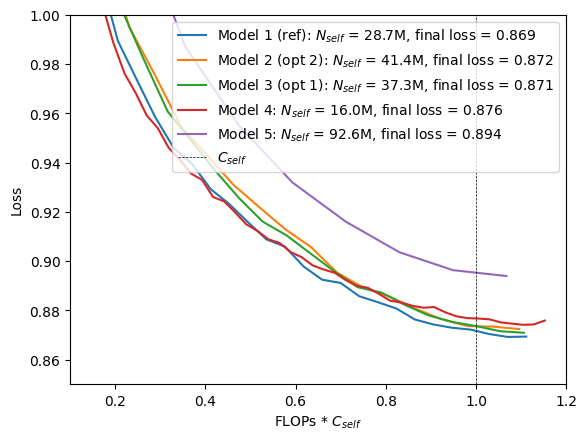

In [18]:
model_labels = ["Model 1 (ref)", "Model 2 (opt 2)", "Model 3 (opt 1)", "Model 4", "Model 5"]

plot_experiment(models, model_labels, experiment_name="scaling-2a")
plt.xlim(0.1, 1.2)
plt.ylim(0.85, 1.0);

Another reason might be that the model size differences between the reference model and the predicted compute-optimal models are too small. This is supported by the higher losses of models 4 and 5. In \[1\] section 3.2, the authors also used "a diverse enough set of model sizes" in order to observe a clear minimum in the IsoFLOPs profiles. 

### Experiment 2b

Another reason for the observed overestimate of compute-optimal model sizes in Experiment 2a could be the longer prefix sequence compared to Experiment 1. To verify that, I used a shorter prefix sequence of length $m = 1536$ for models 1 and 2.

In [19]:
ce = ComputeEstimator(max_seq_len=2048, num_latents=num_latents)
m_ref = ModelInfo(vocab_size=vocab_size, num_channels=512, num_layers=9, num_heads=num_heads, compute_estimator=ce)
models = [m_ref, ModelInfo(vocab_size=vocab_size, num_channels=584, num_layers=10, num_heads=num_heads, compute_estimator=ce)]

c_ref, d_ref = training_flops(ref_model=m_ref, num_steps=26144, batch_size=batch_size)

experiment_setup(models, c_ref=c_ref, batch_size=batch_size)

,num_channels,num_layers,num_steps,$D_{iso}$,$N$,$N_{cross}$,$N_{self}$,$C$,$C_{cross}$,$C_{self}$,$\hat{C}_{self}$
1,512,9,26144,1.07e+09,2.95e+07,7.86e+05,2.87e+07,2.23e+17,1.02e+16,2.13e+17,1.85e+17
2,584,10,18417,7.54e+08,4.23e+07,8.97e+05,4.14e+07,2.21e+17,8.73e+15,2.13e+17,1.87e+17


<figure>
<i>Table 5</i>: Experiment 2b setup.
</figure>

[Training](https://github.com/krasserm/perceiver-io/blob/main/examples/scaling/clm/train.md#experiment-2b) these two models results again in a higher loss for the predicted compute-optimal model i.e. the scaling laws also overestimate the optimal model size here. This suggest that the smaller vocabulary rather than a longer prefix sequence is the reason why the experimental results do not match the prediction.

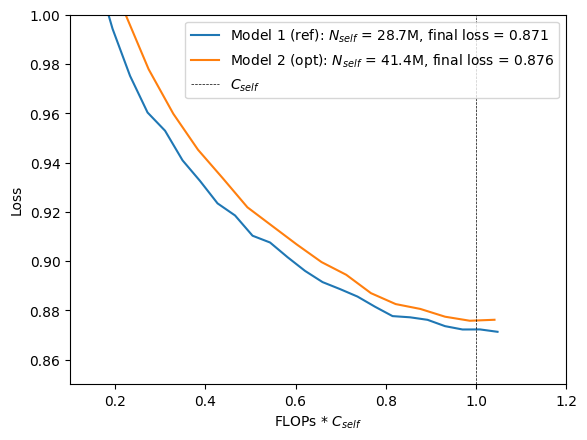

In [20]:
model_labels = ["Model 1 (ref)", "Model 2 (opt)"]

plot_experiment(models, model_labels, experiment_name="scaling-2b")
plt.xlim(0.1, 1.2)
plt.ylim(0.85, 1.0);

## Conclusion

Scaling law predictions match the experimental results when the same tokenizer as in the *Chinchilla* paper \[1\] is used (a SentencePiece tokenizer) but they seem to overestimate the optimal model size $N_{opt}$ when using a UTF-8 bytes tokenizer which uses a much smaller vocabulary. These are results from training Perceiver AR models on a small scale. It needs to be investigated if a similar trend can be observed on larger scale too.

The scaling laws can only be applied to the self-attention part of Perceiver AR since they have been derived from training data of decoder-only transformers. The small cross-attention contribution to the overall compute must be taken into account separately when allocating a compute budget. The direct impact of prefix cross-attention on model performance, under a given compute budget, was not analyzed here and requires further experiments.

## References

\[1\] J. Hoffmann, S. Borgeaud, A. Mensch, E. Buchatskaya, T. Cai, E. Rutherford, D. de Las Casas, L. A. Hendricks, J. Welbl, A. Clark, et al. Training compute-optimal large language models. [arXiv preprint arXiv:2203.15556](https://arxiv.org/abs/2203.15556), 2022.

\[2\] C. Hawthorne, A. Jaegle, C. Cangea, S. Borgeaud, C. Nash, M. Malinowski, S. Dieleman, O. Vinyals, M. Botvinick, I. Simon et al. General-purpose, long-context autoregressive modeling with Perceiver
AR. [arXiv preprint arXiv:2202.07765](https://arxiv.org/abs/2202.07765), 2022.

\[3\] J. Kaplan, S. McCandlish, T. Henighan, T. B. Brown, B. Chess, R. Child, S. Gray, A. Radford, J. Wu,
and D. Amodei. Scaling laws for neural language models. [arXiv preprint arXiv:2001.08361](https://arxiv.org/abs/2001.08361), 2020.

\[4\] https://github.com/karpathy/nanoGPT/blob/master/scaling_laws.ipynb

\[5\] https://news.ycombinator.com/item?id=34342427